In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
train_set = MNIST(root='.', train=True, download=True, transform=ToTensor())
test_set = MNIST(root='.', train=False, download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 55473630.95it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1970711.49it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12200222.62it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1854968.72it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(60000, 10000)

In [3]:
len(train_set), len(test_set)

(60000, 10000)

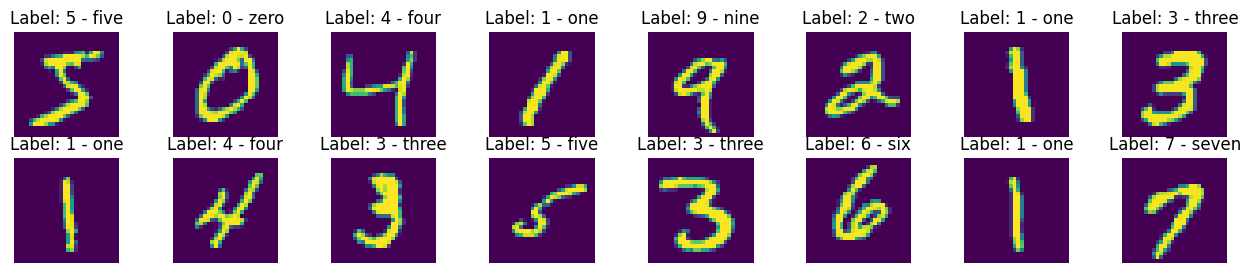

In [6]:
plt.figure(figsize = (16, 3))
for k, (image, label) in enumerate(train_set):
    if k >= 16:
        break
    plt.subplot(2, 8, k+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Label: {train_set.classes[label]}')
    plt.axis('off')

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [8]:
len(train_loader), len(test_loader)

(938, 157)

In [10]:
60000/64, 10000/64

(937.5, 156.25)

In [11]:
xx, yy = next(iter(train_loader))
xx.shape, yy.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [26]:
for x, y in train_loader:
  print(x.shape, y.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


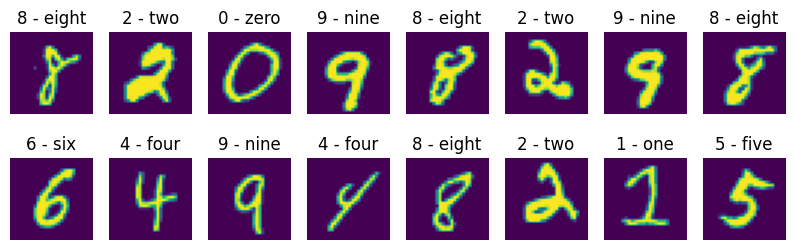

In [17]:
plt.figure(figsize = (10, 3))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(xx[i].permute(1, 2, 0))
    plt.title(train_set.classes[yy[i]])
    plt.axis('off')

In [19]:
xx.shape

torch.Size([64, 1, 28, 28])

In [23]:
xx.flatten(start_dim=1).shape

torch.Size([64, 784])

[(W - K + 2P)/S + 1] x [(W - K + 2P)/S + 1]

---


W - weight
K - kernel_size
P - padding
S - stride

In [30]:
class CNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # 64, 1, 28, 28 -> 64, 32, 28, 28
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 64, 32, 28, 28 -> 64, 32, 14, 14
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1), # 64, 32, 14, 14 -> 64, 16, 12, 12
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 64, 32, 12, 12 -> 64, 32, 6, 6
        nn.Flatten(start_dim=1),
        nn.Linear(16 * 6 * 6, 10)
    )
  def forward(self, x):
    return self.layers(x)

In [31]:
model = CNNClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

In [32]:
for epoch in range(8):
  for x, y in train_loader:
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()
  print(f'Epoch {epoch+1}/8 -> los={loss_value.item():.4f}')

Epoch 1/8 -> los=0.1866
Epoch 2/8 -> los=0.0390
Epoch 3/8 -> los=0.1287
Epoch 4/8 -> los=0.0245
Epoch 5/8 -> los=0.0486
Epoch 6/8 -> los=0.0220
Epoch 7/8 -> los=0.1378
Epoch 8/8 -> los=0.0079


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



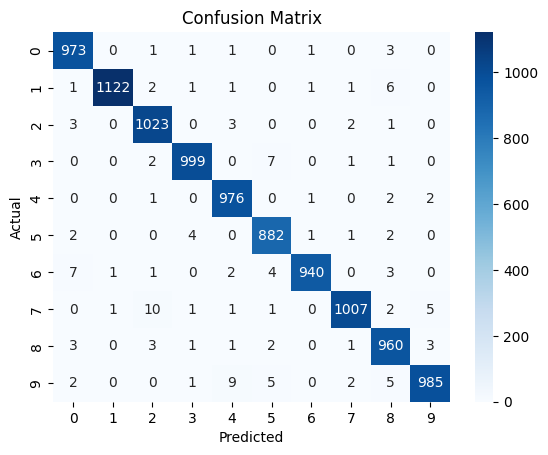

In [34]:
# Assuming you want to evaluate the model on the entire test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
  for x, y in test_loader:
    outputs = model(x)
    predicted = torch.argmax(outputs, dim=1)
    y_true.extend(y.numpy())
    y_pred.extend(predicted.numpy())

# Classification report
print(classification_report(y_true, y_pred))


# Confusion matrix
cm = conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
print(f'Accuracy score - {accuracy_score(y_true, y_pred)}')

Accuracy score - 0.9867
